# 競馬予想で学ぶディープラーニング入門

*   なるべく難しい数学は使わない
*   実際に競馬予想に用いてみる



# 1: ニューラルネットワーク
$$ y =
\left\{
\begin{array}{}
1\quad(w_1x_1+w_2x_2 \geq \theta) \\ 
0 \quad(w_1x_1+w_2x_2 < \theta)
\end{array}
\right.
$$

θの代わりに、バイアスbを用いて

$$y =
\left\{
\begin{array}{}
1\quad(w_1x_1+w_2x_2+b \geq 0) \\ 
0\quad(w_1x_1+w_2x_2 +b < 0)
\end{array}
\right.
$$

シグモイド関数

$$ \sigma(x)=\frac{1}{1+e^{-x}} $$

を用いると

$$ y=\sigma(w_1x_1+w_2x_2+b) $$

$$
\left(
\begin{array}{c}
a_1 \\
a_2 \\
\vdots \\
a_n
\end{array}
\right)
$$

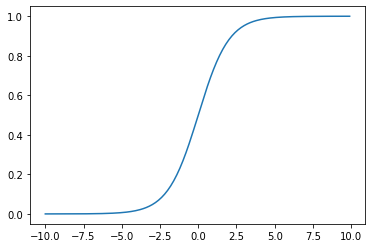

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid(x))

ANDゲート

In [ ]:
import torch

X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]])
t = torch.Tensor([[0], [1], [1], [1]])
X

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

In [ ]:
t

tensor([[0.],
        [1.],
        [1.],
        [1.]])

In [ ]:
# 入力2, 出力1のネットワーク
from torch import nn

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [ ]:
y = model(X)

In [ ]:
y

tensor([[0.5168],
        [0.5282],
        [0.5243],
        [0.5357]], grad_fn=<SigmoidBackward>)

#2: 学習のさせ方
平均二乗誤差(損失関数)
$$ E(w_1, w_2, b) = \frac{1}{4}\sum^{3}_{n=0} (t_n-y_n)^2 $$

損失関数を最小化させる引数を求めたい

* 勾配降下法
$$w_1←w_1-\eta\frac{ \partial E(w_1, w_2, b)}{\partial w_1}$$
$$w_2←w_2-\eta\frac{ \partial E(w_1, w_2, b)}{\partial w_2}$$
$$b←b-\eta\frac{ \partial E(w_1, w_2, b)}{\partial b}$$

η: learning-rate(=lr)

*   大きすぎると、大雑把な動きしかできずに適切な位置に着地できない。
*   小さすぎると、本来着地すべきでない位置に誤って着地してしまう（局所解が求まってしまう。)



In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
from torch import optim

# SGD(stochastic gradient descent) : 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
model.train()
for epoch in range(5000):
  optimizer.zero_grad()
  y = model(X)
  loss = loss_fn(y, t)

  # 傾きの計算
  loss.backward()
  optimizer.step()

In [ ]:
model(X) # 学習できる例

# tensor([[0.1209],
#         [0.9258],
#         [0.9258],
#         [0.9991]], grad_fn=<SigmoidBackward>)

tensor([[0.1209],
        [0.9258],
        [0.9258],
        [0.9991]], grad_fn=<SigmoidBackward>)

In [ ]:
t

tensor([[0.],
        [1.],
        [1.],
        [1.]])

In [ ]:
loss_fn(model(X), t)

tensor(0.0064, grad_fn=<MseLossBackward>)

XORゲートでも同様のことを行う。　→ 線形的に分割が不可能なので学習が実質不可能

In [ ]:
X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]])
t = torch.Tensor([[0], [1], [1], [0]])

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model.train()
for epoch in range(5000):
  optimizer.zero_grad()
  y = model(X)
  loss = loss_fn(y, t)

  # 傾きの計算
  loss.backward()
  optimizer.step()

In [ ]:
model(X) # 学習できない例

# tensor([[0.5201],
#         [0.4140],
#         [0.5961],
#         [0.4903]], grad_fn=<SigmoidBackward>)

tensor([[0.5201],
        [0.4140],
        [0.5961],
        [0.4903]], grad_fn=<SigmoidBackward>)

層を増やすことで非線形性にも対応可能

→名前がDeepである所以

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(model.parameters(), lr=0.05)

model.train()
for epoch in range(100000):
  optimizer.zero_grad()
  y = model(X)
  loss = loss_fn(y, t)

  # 傾きの計算
  loss.backward()
  optimizer.step()

In [ ]:
model(X) # 層を増やすことで学習できた

# tensor([[0.0344],
#         [0.9615],
#         [0.9668],
#         [0.0309]], grad_fn=<SigmoidBackward>)

tensor([[0.0344],
        [0.9615],
        [0.9668],
        [0.0309]], grad_fn=<SigmoidBackward>)

# 3: ディープラーニングを競馬予想に活用する

In [122]:
# googledriveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
results=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results_5R.pickle')

In [ ]:
# DataFrameをtrain_dataとtest_dataに分割する関数。
def split_data(df, test_size=0.3):
  sorted_id_list = df.sort_values('date').index.unique()
  train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
  test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
  train_data = df.loc[train_id_list].drop(['date'], axis=1)
  test_data = df.loc[test_id_list].drop(['date'], axis=1)
  return train_data, test_data

In [ ]:
results.head()

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank
201901010101,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,05339,牡,2,518,-16,3.0,180.0,1
201901010101,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,05203,牡,2,496,-8,2.0,280.0,1
201901010101,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,01180,牡,2,546,6,10.0,0.0,1
201901010101,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,01179,牡,2,458,-8,4.0,110.0,0
201901010101,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,01062,牡,2,436,0,9.0,0.0,0


In [ ]:
results.index.nunique()

3452

In [ ]:
results_d = pd.get_dummies(results).fillna(0)
train, test = split_data(results_d, test_size=0.3)
X_train = train.drop(['rank'], axis=1)
t_train = train['rank']
X_test = test.drop(['rank'], axis=1)
t_test = test['rank']

In [ ]:
X_train.head()

,枠番,馬番,斤量,単勝,人気,course_len,年齢,体重,体重変化,着順_5R,賞金_5R,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,jockey_id_00422,jockey_id_00641,jockey_id_00652,jockey_id_00660,jockey_id_00663,jockey_id_00666,jockey_id_00684,jockey_id_00689,jockey_id_00691,jockey_id_00695,jockey_id_00700,jockey_id_00722,jockey_id_00726,jockey_id_00727,jockey_id_00732,jockey_id_00733,...,jockey_id_05389,jockey_id_05390,jockey_id_05404,jockey_id_05411,jockey_id_05420,jockey_id_05427,jockey_id_05429,jockey_id_05469,jockey_id_05470,jockey_id_05478,jockey_id_05492,jockey_id_05495,jockey_id_05512,jockey_id_05517,jockey_id_05524,jockey_id_05525,jockey_id_05533,jockey_id_05534,jockey_id_05542,jockey_id_05543,jockey_id_05548,jockey_id_05555,jockey_id_05563,jockey_id_05568,jockey_id_05573,jockey_id_05575,jockey_id_05576,jockey_id_05577,jockey_id_05578,jockey_id_05580,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201906010101,5,9,56.0,3.9,2.0,1200,3,500,14,3.0,180.000000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201906010101,7,14,52.0,76.2,11.0,1200,3,448,10,8.5,37.500000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
201906010101,5,10,56.0,5.6,3.0,1200,3,454,6,5.2,76.000000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201906010101,3,6,54.0,2.4,1.0,1200,3,474,-2,3.0,151.666667,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
201906010101,4,8,56.0,11.8,5.0,1200,3,438,4,4.5,81.250000,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_train = torch.Tensor(X_train.values)
t_train = torch.Tensor(t_train.values)
X_test = torch.Tensor(X_test.values)
t_test = torch.Tensor(t_test.values)

In [ ]:
t_train.reshape(-1, 1) # x * 1次元に変換

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [ ]:
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

In [ ]:
model = nn.Sequential(
    nn.Linear(221, 128),
    nn.Sigmoid(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [ ]:
model(X_train)

tensor([[0.4684],
        [0.4862],
        [0.4669],
        ...,
        [0.4732],
        [0.4684],
        [0.4736]], grad_fn=<SigmoidBackward>)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
from tqdm import tqdm

model.train()
for epoch in tqdm(range(100)):
  optimizer.zero_grad()
  y_train = model(X_train)
  loss = loss_fn(y_train, t_train)

  loss.backward()
  optimizer.step()

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


In [ ]:
model(X_train)

tensor([[0.3170],
        [0.2073],
        [0.2921],
        ...,
        [0.3222],
        [0.2559],
        [0.3219]], grad_fn=<SigmoidBackward>)

In [ ]:
t_train.numpy()

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
y_train = model(X_train)
y_test = model(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(t_train.detach().numpy(), y_train.detach().numpy())
# 0.6910971897004454

0.6910971897004454

In [ ]:
roc_auc_score(t_test.detach().numpy(), y_test.detach().numpy())
# 0.6737151628081162

0.6737151628081162

# 4: ミニバッチ学習

In [ ]:
model = nn.Sequential(
    nn.Linear(221, 128),
    nn.Sigmoid(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, t_train)
# batch_sizeは50~500程度
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
from sklearn.metrics import roc_auc_score

for epoch in range(10):
  model.train()
  for X, t in loader:
    optimizer.zero_grad()
    y = model(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()
  
  model.eval()
  y_train = model(X_train)
  y_test = model(X_test)
  loss_train = loss_fn(y_train, t_train)
  loss_test = loss_fn(y_test, t_test)
  auc_train = roc_auc_score(t_train.detach().numpy(), y_train.detach().numpy())
  auc_test = roc_auc_score(t_test.detach().numpy(), y_test.detach().numpy())

  print('epoch: {}, train: [loss={:.3f}, AUC={:.3f}], test:[loss={:.3f}, AUC={:.3f}]'.format(epoch, loss_train, auc_train, loss_test, auc_test))

# あまり精度が上がらない
# epoch: 0, train: [loss=0.171, AUC=0.631], test:[loss=0.173, AUC=0.628]
# epoch: 1, train: [loss=0.168, AUC=0.669], test:[loss=0.170, AUC=0.655]
# epoch: 2, train: [loss=0.166, AUC=0.690], test:[loss=0.168, AUC=0.672]
# epoch: 3, train: [loss=0.169, AUC=0.662], test:[loss=0.170, AUC=0.655]
# epoch: 4, train: [loss=0.168, AUC=0.657], test:[loss=0.170, AUC=0.631]
# epoch: 5, train: [loss=0.168, AUC=0.571], test:[loss=0.170, AUC=0.573]
# epoch: 6, train: [loss=0.165, AUC=0.650], test:[loss=0.168, AUC=0.631]
# epoch: 7, train: [loss=0.164, AUC=0.660], test:[loss=0.167, AUC=0.656]
# epoch: 8, train: [loss=0.164, AUC=0.688], test:[loss=0.167, AUC=0.659]
# epoch: 9, train: [loss=0.166, AUC=0.606], test:[loss=0.168, AUC=0.595]

epoch: 0, train: [loss=0.171, AUC=0.631], test:[loss=0.173, AUC0.628]
epoch: 1, train: [loss=0.168, AUC=0.669], test:[loss=0.170, AUC0.655]
epoch: 2, train: [loss=0.166, AUC=0.690], test:[loss=0.168, AUC0.672]
epoch: 3, train: [loss=0.169, AUC=0.662], test:[loss=0.170, AUC0.655]
epoch: 4, train: [loss=0.168, AUC=0.657], test:[loss=0.170, AUC0.631]
epoch: 5, train: [loss=0.168, AUC=0.571], test:[loss=0.170, AUC0.573]
epoch: 6, train: [loss=0.165, AUC=0.650], test:[loss=0.168, AUC0.631]
epoch: 7, train: [loss=0.164, AUC=0.660], test:[loss=0.167, AUC0.656]
epoch: 8, train: [loss=0.164, AUC=0.688], test:[loss=0.167, AUC0.659]
epoch: 9, train: [loss=0.166, AUC=0.606], test:[loss=0.168, AUC0.595]


## 4.1: BatchNormalization

Input: Values of x over a mini-batch B={x_1...m}(m=batch_size);

　　　Parameters to be leamed: γ, β

Output: {y_i=BN_γ, β(x_i)}

$$\mu_{B} ← \frac{1}{m}\sum^{m}_{i=1}x_i$$

$$ \sigma^2_{B} ← \frac{1}{m}\sum^{m}_{i=1}(x_i-\mu_{B})^2$$

$$ \hat{x_i} ← \frac{x_i-\mu_{B}}{\sigma^2_{B}+\epsilon} $$

$$ y_i ← \gamma \hat{x_i}+\beta \equiv BN_{γ, β}(x_i)$$

In [ ]:
from torch import optim

model = nn.Sequential(
    nn.Linear(221, 128),
    nn.BatchNorm1d(128),
    nn.Sigmoid(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
loss_fn =  nn.MSELoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
from sklearn.metrics import roc_auc_score

for epoch in range(10):
  model.train()
  for X, t in loader:
    optimizer.zero_grad()
    y = model(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()
  
  model.eval()
  y_train = model(X_train)
  y_test = model(X_test)
  loss_train = loss_fn(y_train, t_train)
  loss_test = loss_fn(y_test, t_test)
  auc_train = roc_auc_score(t_train.detach().numpy(), y_train.detach().numpy())
  auc_test = roc_auc_score(t_test.detach().numpy(), y_test.detach().numpy())

  print('epoch: {}, train: [loss={:.3f}, AUC={:.3f}], test:[loss={:.3f}, AUC={:.3f}]'.format(epoch, loss_train, auc_train, loss_test, auc_test))

# AUC, loss共に精度が良くなった
# epoch: 0, train: [loss=0.144, AUC=0.797], test:[loss=0.147, AUC=0.791]
# epoch: 1, train: [loss=0.152, AUC=0.803], test:[loss=0.154, AUC=0.798]
# epoch: 2, train: [loss=0.176, AUC=0.794], test:[loss=0.178, AUC=0.791]
# epoch: 3, train: [loss=0.139, AUC=0.807], test:[loss=0.141, AUC=0.803]
# epoch: 4, train: [loss=0.139, AUC=0.812], test:[loss=0.141, AUC=0.807]
# epoch: 5, train: [loss=0.157, AUC=0.790], test:[loss=0.159, AUC=0.785]
# epoch: 6, train: [loss=0.138, AUC=0.805], test:[loss=0.141, AUC=0.799]
# epoch: 7, train: [loss=0.155, AUC=0.807], test:[loss=0.158, AUC=0.802]
# epoch: 8, train: [loss=0.139, AUC=0.812], test:[loss=0.141, AUC=0.807]
# epoch: 9, train: [loss=0.139, AUC=0.809], test:[loss=0.141, AUC=0.803]

epoch: 0, train: [loss=0.144, AUC=0.797], test:[loss=0.147, AUC=0.791]
epoch: 1, train: [loss=0.152, AUC=0.803], test:[loss=0.154, AUC=0.798]
epoch: 2, train: [loss=0.176, AUC=0.794], test:[loss=0.178, AUC=0.791]
epoch: 3, train: [loss=0.139, AUC=0.807], test:[loss=0.141, AUC=0.803]
epoch: 4, train: [loss=0.139, AUC=0.812], test:[loss=0.141, AUC=0.807]
epoch: 5, train: [loss=0.157, AUC=0.790], test:[loss=0.159, AUC=0.785]
epoch: 6, train: [loss=0.138, AUC=0.805], test:[loss=0.141, AUC=0.799]
epoch: 7, train: [loss=0.155, AUC=0.807], test:[loss=0.158, AUC=0.802]
epoch: 8, train: [loss=0.139, AUC=0.812], test:[loss=0.141, AUC=0.807]
epoch: 9, train: [loss=0.139, AUC=0.809], test:[loss=0.141, AUC=0.803]


## 4.2: Adam

In [ ]:
from torch import optim

model = nn.Sequential(
    nn.Linear(221, 128),
    nn.BatchNorm1d(128),
    nn.Sigmoid(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
loss_fn =  nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
from sklearn.metrics import roc_auc_score

for epoch in range(10):
  model.train()
  for X, t in loader:
    optimizer.zero_grad()
    y = model(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()
  
  model.eval()
  y_train = model(X_train)
  y_test = model(X_test)
  loss_train = loss_fn(y_train, t_train)
  loss_test = loss_fn(y_test, t_test)
  auc_train = roc_auc_score(t_train.detach().numpy(), y_train.detach().numpy())
  auc_test = roc_auc_score(t_test.detach().numpy(), y_test.detach().numpy())

  print('epoch: {}, train: [loss={:.3f}, AUC={:.3f}], test:[loss={:.3f}, AUC={:.3f}]'.format(epoch, loss_train, auc_train, loss_test, auc_test))

# epoch: 0, train: [loss=0.179, AUC=0.778], test:[loss=0.182, AUC=0.769]
# epoch: 1, train: [loss=0.163, AUC=0.806], test:[loss=0.164, AUC=0.800]
# epoch: 2, train: [loss=0.137, AUC=0.811], test:[loss=0.140, AUC=0.805]
# epoch: 3, train: [loss=0.142, AUC=0.809], test:[loss=0.146, AUC=0.802]
# epoch: 4, train: [loss=0.139, AUC=0.808], test:[loss=0.141, AUC=0.801]
# epoch: 5, train: [loss=0.142, AUC=0.812], test:[loss=0.144, AUC=0.805]
# epoch: 6, train: [loss=0.161, AUC=0.808], test:[loss=0.166, AUC=0.802]
# epoch: 7, train: [loss=0.159, AUC=0.810], test:[loss=0.161, AUC=0.803]
# epoch: 8, train: [loss=0.134, AUC=0.810], test:[loss=0.138, AUC=0.803]
# epoch: 9, train: [loss=0.134, AUC=0.812], test:[loss=0.137, AUC=0.805]

epoch: 0, train: [loss=0.179, AUC=0.778], test:[loss=0.182, AUC=0.769]
epoch: 1, train: [loss=0.163, AUC=0.806], test:[loss=0.164, AUC=0.800]
epoch: 2, train: [loss=0.137, AUC=0.811], test:[loss=0.140, AUC=0.805]
epoch: 3, train: [loss=0.142, AUC=0.809], test:[loss=0.146, AUC=0.802]
epoch: 4, train: [loss=0.139, AUC=0.808], test:[loss=0.141, AUC=0.801]
epoch: 5, train: [loss=0.142, AUC=0.812], test:[loss=0.144, AUC=0.805]
epoch: 6, train: [loss=0.161, AUC=0.808], test:[loss=0.166, AUC=0.802]
epoch: 7, train: [loss=0.159, AUC=0.810], test:[loss=0.161, AUC=0.803]
epoch: 8, train: [loss=0.134, AUC=0.810], test:[loss=0.138, AUC=0.803]
epoch: 9, train: [loss=0.134, AUC=0.812], test:[loss=0.137, AUC=0.805]


# 5: 多クラス分類

*   分類先が複数



In [214]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train = FashionMNIST('FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
test = FashionMNIST('FashionMNIST', train=True, download=False, transform=transforms.ToTensor())

In [215]:
X_train = train.data.type(torch.float32)
t_train = train.targets
X_test = test.data.type(torch.float32)
t_test = test.targets

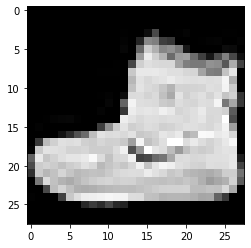

In [216]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap='gray')

In [217]:
from torch.utils.data import TensorDataset, DataLoader

ds_train = TensorDataset(X_train, t_train)
ds_test = TensorDataset(X_test, t_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=True)

In [218]:
X_train.shape

torch.Size([60000, 28, 28])

In [228]:
from torch import nn

n_in = 28*28
n_mid = 128
n_out = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_in, n_mid),
    nn.Sigmoid(),
    nn.Linear(n_mid, n_mid),
    nn.Sigmoid(),
    nn.Linear(n_mid, n_out)
)

In [229]:
model(X_train)

tensor([[ 0.0445, -0.2624,  0.1864,  ...,  0.2385, -0.2226, -0.6318],
        [ 0.0529, -0.2205,  0.1911,  ...,  0.2272, -0.2824, -0.6623],
        [ 0.0288, -0.2607,  0.1596,  ...,  0.2506, -0.2077, -0.6494],
        ...,
        [ 0.0355, -0.2232,  0.1719,  ...,  0.2286, -0.3003, -0.6406],
        [ 0.0221, -0.2361,  0.1545,  ...,  0.2324, -0.2386, -0.6222],
        [ 0.0341, -0.2189,  0.2051,  ...,  0.2030, -0.1891, -0.6094]],
       grad_fn=<AddmmBackward>)

## 5.1: ソフトマックス関数
  * 入力を「確率」にして出力する

  $$
  \left(
  \begin{array}{}
     y_1\\
     y_2\\
     \vdots \\
     y_n\\
  \end{array}
  \right) = \frac{1}{\sum^{10}_{i=1} e^{x_i}}
  \left(
  \begin{array}{}
    e^{x_1} \\
    e^{x_2} \\
    \vdots \\
    e^{x_{10}} \\
  \end{array}
  \right)
  $$

In [230]:
from torch.nn import functional as F

F.softmax(model(X_train), dim=1)

tensor([[0.1145, 0.0842, 0.1319,  ..., 0.1390, 0.0876, 0.0582],
        [0.1171, 0.0891, 0.1345,  ..., 0.1394, 0.0837, 0.0573],
        [0.1128, 0.0845, 0.1286,  ..., 0.1408, 0.0890, 0.0573],
        ...,
        [0.1159, 0.0895, 0.1328,  ..., 0.1406, 0.0828, 0.0589],
        [0.1131, 0.0874, 0.1291,  ..., 0.1396, 0.0871, 0.0594],
        [0.1133, 0.0880, 0.1345,  ..., 0.1342, 0.0907, 0.0596]],
       grad_fn=<SoftmaxBackward>)

In [231]:
t_train

tensor([9, 0, 0,  ..., 3, 0, 5])

## 5.2 : 尤度関数

L=0.0646 * 0.1043 * 0.0755 ...

*   損失関数 : E = -log(L)

(交差エントロピー誤差関数)



In [232]:
# この関数にsoftmax関数も含んでいるため注意
loss_fn = nn.CrossEntropyLoss()

In [233]:
loss_fn(model(X_train), t_train)

tensor(2.3376, grad_fn=<NllLossBackward>)

In [234]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [235]:
import numpy as np

for epoch in range(10):
  model.train()

  loss_train = []
  loss_test = []
  train_num = 0
  train_true_num = 0
  test_num = 0
  test_true_num = 0
  for X, t in loader_train:
    optimizer.zero_grad()
    y = model(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()

    # i行目の最大値が欲しい
    pred = y.argmax(1)
    loss_train.append(loss.tolist())

    # accuracyを求める
    train_num += t.shape[0]
    train_true_num += (pred==t).sum().item()

  model.eval()
  for X, t in loader_test:
    y = model(X)
    loss = loss_fn(y, t)

    # i行目の最大値が欲しい
    pred = y.argmax(1)
    loss_test.append(loss.tolist())

    # accuracyを求める
    test_num += t.shape[0]
    test_true_num += (pred==t).sum().item()
  
  print('EPOCH {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Test: [Loss: {:.3f}, Accuracy: {:.3f}]'\
        .format(epoch, 
                np.mean(loss_train), 
                train_true_num / train_num,
                np.mean(loss_test),
                test_true_num / test_num))

# 層を増やす前のリザルト
# EPOCH 0, Train [Loss: 0.672, Accuracy: 0.757], Test: [Loss: 0.647, Accuracy: 0.781]
# EPOCH 1, Train [Loss: 0.655, Accuracy: 0.762], Test: [Loss: 0.655, Accuracy: 0.763]
# EPOCH 2, Train [Loss: 0.674, Accuracy: 0.758], Test: [Loss: 0.638, Accuracy: 0.776]
# EPOCH 3, Train [Loss: 0.631, Accuracy: 0.765], Test: [Loss: 0.639, Accuracy: 0.766]
# EPOCH 4, Train [Loss: 0.628, Accuracy: 0.766], Test: [Loss: 0.655, Accuracy: 0.753]
# EPOCH 5, Train [Loss: 0.649, Accuracy: 0.756], Test: [Loss: 0.642, Accuracy: 0.764]
# EPOCH 6, Train [Loss: 0.644, Accuracy: 0.759], Test: [Loss: 0.622, Accuracy: 0.761]
# EPOCH 7, Train [Loss: 0.617, Accuracy: 0.772], Test: [Loss: 0.618, Accuracy: 0.777]
# EPOCH 8, Train [Loss: 0.617, Accuracy: 0.772], Test: [Loss: 0.637, Accuracy: 0.775]
# EPOCH 9, Train [Loss: 0.621, Accuracy: 0.774], Test: [Loss: 0.615, Accuracy: 0.778]


# 層を増やした後のリザルト
# EPOCH 0, Train [Loss: 0.980, Accuracy: 0.649], Test: [Loss: 0.739, Accuracy: 0.731]
# EPOCH 1, Train [Loss: 0.740, Accuracy: 0.709], Test: [Loss: 0.691, Accuracy: 0.727]
# EPOCH 2, Train [Loss: 0.713, Accuracy: 0.721], Test: [Loss: 0.801, Accuracy: 0.673]
# EPOCH 3, Train [Loss: 0.730, Accuracy: 0.716], Test: [Loss: 0.746, Accuracy: 0.695]
# EPOCH 4, Train [Loss: 0.733, Accuracy: 0.717], Test: [Loss: 0.739, Accuracy: 0.693]
# EPOCH 5, Train [Loss: 0.686, Accuracy: 0.727], Test: [Loss: 0.668, Accuracy: 0.750]
# EPOCH 6, Train [Loss: 0.667, Accuracy: 0.741], Test: [Loss: 0.694, Accuracy: 0.724]
# EPOCH 7, Train [Loss: 0.681, Accuracy: 0.735], Test: [Loss: 0.672, Accuracy: 0.749]
# EPOCH 8, Train [Loss: 0.692, Accuracy: 0.731], Test: [Loss: 0.706, Accuracy: 0.708]
# EPOCH 9, Train [Loss: 0.673, Accuracy: 0.734], Test: [Loss: 0.685, Accuracy: 0.725]

EPOCH 0, Train [Loss: 0.980, Accuracy: 0.649], Test: [Loss: 0.739, Accuracy: 0.731]
EPOCH 1, Train [Loss: 0.740, Accuracy: 0.709], Test: [Loss: 0.691, Accuracy: 0.727]
EPOCH 2, Train [Loss: 0.713, Accuracy: 0.721], Test: [Loss: 0.801, Accuracy: 0.673]
EPOCH 3, Train [Loss: 0.730, Accuracy: 0.716], Test: [Loss: 0.746, Accuracy: 0.695]
EPOCH 4, Train [Loss: 0.733, Accuracy: 0.717], Test: [Loss: 0.739, Accuracy: 0.693]
EPOCH 5, Train [Loss: 0.686, Accuracy: 0.727], Test: [Loss: 0.668, Accuracy: 0.750]
EPOCH 6, Train [Loss: 0.667, Accuracy: 0.741], Test: [Loss: 0.694, Accuracy: 0.724]
EPOCH 7, Train [Loss: 0.681, Accuracy: 0.735], Test: [Loss: 0.672, Accuracy: 0.749]
EPOCH 8, Train [Loss: 0.692, Accuracy: 0.731], Test: [Loss: 0.706, Accuracy: 0.708]
EPOCH 9, Train [Loss: 0.673, Accuracy: 0.734], Test: [Loss: 0.685, Accuracy: 0.725]


## 5.3: 勾配消失問題

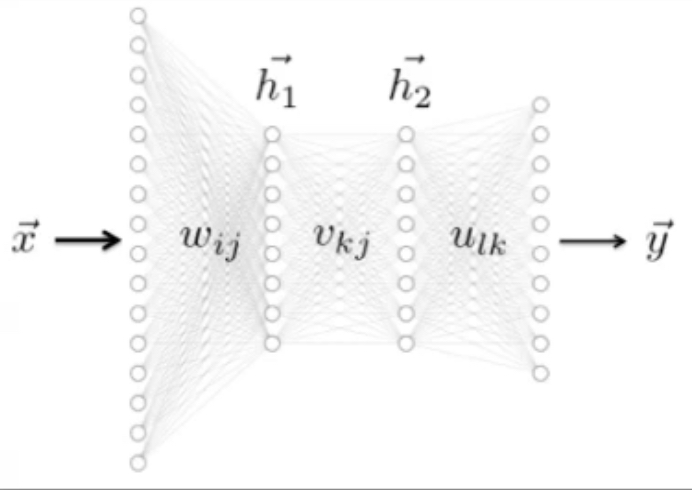

$$W = \{w_{ij}\}, V=\{v_{kj}\}, U=\{u_{lk}\}$$
$$\vec{p}=W\vec{x}+\vec{b}$$
$$\vec{h_1}=\sigma(\vec{p})$$
$$\vec{q}=V\vec{h_1}+\vec{c}$$
$$\vec{h_2}=\sigma(\vec{q})$$
$$\vec{r}=U\vec{h_2}+\vec{d}$$
$$\vec{y}=softmax(\vec{r})$$

In [239]:
class Net(nn.Module):
  def __init__(self, n_in, n_out, n_mid=128):
    super(Net, self).__init__()
    self.W = nn.Linear(n_in, n_mid)
    self.V = nn.Linear(n_mid, n_mid)
    self.U = nn.Linear(n_mid, n_out)
  
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    p = self.W(x)
    h1 = torch.relu(p)
    q = self.V(h1)
    h2 = torch.relu(q)
    r = self.U(h2)
    return r

model = Net(n_in=n_in, n_out=n_out)
optimizer = optim.Adam(model.parameters())

勾配降下法では、
$$\vec{w_j}←\vec{w_j}-\eta \frac{\partial E}{\partial \vec{w_j}}$$
ここで、偏微分の連鎖率から、
$$\frac{\partial E}{\partial \vec{w_j}} = \frac{\partial E}{\partial p_{j}} \frac{\partial p_{j}}{\partial \vec{w_j}}=\frac{\partial E}{\partial p_j}\vec{x}$$
$$\frac{\partial E}{\partial p_j} = \sum_l \sum _k \sigma^{\prime}(q_k) \sigma^{\prime}(p_j) \frac{\partial E}{\partial r_{l}}$$
最終層での誤差が、「活性化関数の微分」を掛けながら、ネットワークを通って「逆向きに伝搬してくる」イメージ。

(復習)

シグモイド関数
$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

これを微分すると、
$$ \sigma^{\prime}(x) = \sigma(x)(1-\sigma(x)) $$
$$ max(\sigma(x)) = 1 $$
に対して、
$$ max(\sigma^{\prime}(x)) = 0.25 $$
であるため、
$$max(\sigma^{\prime}(q_k) \sigma^{\prime}(p_j)) = 0.25 ** 2 = 0.0625$$
これが悪影響を及ぼしている。(そうを重ねるほど、更新式への影響が小さくなる。）

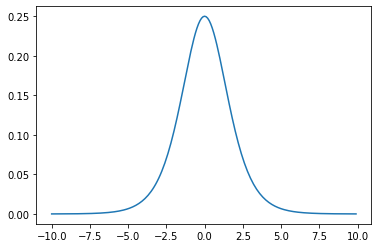

In [162]:
def sigmoid_dif(x):
  return sigmoid(x)*(1-sigmoid(x))

x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid_dif(x))

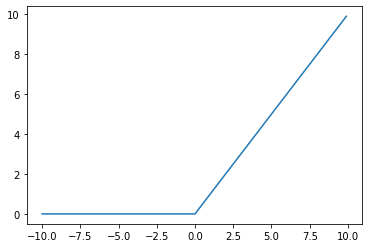

In [164]:
def relu(x):
  return np.maximum(0, x)
x = np.arange(-10, 10, 0.1)
plt.plot(x, relu(x))

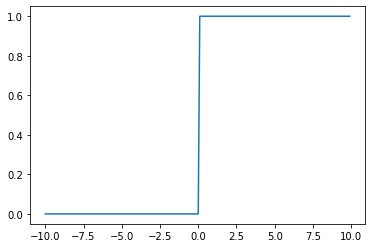

In [191]:
def relu_dif(x):
  return list(map(lambda X: 0 if X<0 else 1, x))
x = np.arange(-10, 10, 0.1)
plt.plot(x, relu_dif(x))

In [240]:
import numpy as np

for epoch in range(10):
  model.train()

  loss_train = []
  loss_test = []
  train_num = 0
  train_true_num = 0
  test_num = 0
  test_true_num = 0
  for X, t in loader_train:
    optimizer.zero_grad()
    y = model.forward(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()

    # i行目の最大値が欲しい
    pred = y.argmax(1)
    loss_train.append(loss.tolist())

    # accuracyを求める
    train_num += t.shape[0]
    train_true_num += (pred==t).sum().item()

  model.eval()
  for X, t in loader_test:
    y = model.forward(X)
    loss = loss_fn(y, t)

    # i行目の最大値が欲しい
    pred = y.argmax(1)
    loss_test.append(loss.tolist())

    # accuracyを求める
    test_num += t.shape[0]
    test_true_num += (pred==t).sum().item()
  
  print('EPOCH {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Test: [Loss: {:.3f}, Accuracy: {:.3f}]'\
        .format(epoch, 
                np.mean(loss_train), 
                train_true_num / train_num,
                np.mean(loss_test),
                test_true_num / test_num))

# 層を増やす前のリザルト
# EPOCH 0, Train [Loss: 0.899, Accuracy: 0.715], Test: [Loss: 0.731, Accuracy: 0.747]
# EPOCH 1, Train [Loss: 0.709, Accuracy: 0.740], Test: [Loss: 0.701, Accuracy: 0.726]
# EPOCH 2, Train [Loss: 0.688, Accuracy: 0.741], Test: [Loss: 0.678, Accuracy: 0.725]
# EPOCH 3, Train [Loss: 0.667, Accuracy: 0.746], Test: [Loss: 0.658, Accuracy: 0.761]
# EPOCH 4, Train [Loss: 0.664, Accuracy: 0.756], Test: [Loss: 0.642, Accuracy: 0.765]
# EPOCH 5, Train [Loss: 0.659, Accuracy: 0.753], Test: [Loss: 0.702, Accuracy: 0.709]
# EPOCH 6, Train [Loss: 0.672, Accuracy: 0.741], Test: [Loss: 0.657, Accuracy: 0.754]
# EPOCH 7, Train [Loss: 0.668, Accuracy: 0.748], Test: [Loss: 0.688, Accuracy: 0.747]
# EPOCH 8, Train [Loss: 0.663, Accuracy: 0.751], Test: [Loss: 0.665, Accuracy: 0.748]
# EPOCH 9, Train [Loss: 0.652, Accuracy: 0.749], Test: [Loss: 0.648, Accuracy: 0.765]

# 層を増やした後のリザルト
# EPOCH 0, Train [Loss: 0.961, Accuracy: 0.664], Test: [Loss: 0.755, Accuracy: 0.708]
# EPOCH 1, Train [Loss: 0.745, Accuracy: 0.710], Test: [Loss: 0.711, Accuracy: 0.712]
# EPOCH 2, Train [Loss: 0.726, Accuracy: 0.718], Test: [Loss: 0.733, Accuracy: 0.731]
# EPOCH 3, Train [Loss: 0.706, Accuracy: 0.724], Test: [Loss: 0.678, Accuracy: 0.720]
# EPOCH 4, Train [Loss: 0.684, Accuracy: 0.737], Test: [Loss: 0.687, Accuracy: 0.734]
# EPOCH 5, Train [Loss: 0.697, Accuracy: 0.726], Test: [Loss: 0.670, Accuracy: 0.729]
# EPOCH 6, Train [Loss: 0.674, Accuracy: 0.746], Test: [Loss: 0.673, Accuracy: 0.750]
# EPOCH 7, Train [Loss: 0.665, Accuracy: 0.745], Test: [Loss: 0.673, Accuracy: 0.741]
# EPOCH 8, Train [Loss: 0.655, Accuracy: 0.751], Test: [Loss: 0.650, Accuracy: 0.749]
# EPOCH 9, Train [Loss: 0.640, Accuracy: 0.752], Test: [Loss: 0.592, Accuracy: 0.777]

# 勾配消失問題解決後のリザルト
# EPOCH 0, Train [Loss: 0.687, Accuracy: 0.793], Test: [Loss: 0.501, Accuracy: 0.810]
# EPOCH 1, Train [Loss: 0.444, Accuracy: 0.839], Test: [Loss: 0.397, Accuracy: 0.856]
# EPOCH 2, Train [Loss: 0.407, Accuracy: 0.852], Test: [Loss: 0.452, Accuracy: 0.845]
# EPOCH 3, Train [Loss: 0.389, Accuracy: 0.858], Test: [Loss: 0.355, Accuracy: 0.872]
# EPOCH 4, Train [Loss: 0.368, Accuracy: 0.866], Test: [Loss: 0.342, Accuracy: 0.878]
# EPOCH 5, Train [Loss: 0.356, Accuracy: 0.870], Test: [Loss: 0.335, Accuracy: 0.875]
# EPOCH 6, Train [Loss: 0.347, Accuracy: 0.874], Test: [Loss: 0.334, Accuracy: 0.880]
# EPOCH 7, Train [Loss: 0.341, Accuracy: 0.876], Test: [Loss: 0.310, Accuracy: 0.887]
# EPOCH 8, Train [Loss: 0.330, Accuracy: 0.881], Test: [Loss: 0.297, Accuracy: 0.890]
# EPOCH 9, Train [Loss: 0.324, Accuracy: 0.881], Test: [Loss: 0.294, Accuracy: 0.890]

EPOCH 0, Train [Loss: 0.687, Accuracy: 0.793], Test: [Loss: 0.501, Accuracy: 0.810]
EPOCH 1, Train [Loss: 0.444, Accuracy: 0.839], Test: [Loss: 0.397, Accuracy: 0.856]
EPOCH 2, Train [Loss: 0.407, Accuracy: 0.852], Test: [Loss: 0.452, Accuracy: 0.845]
EPOCH 3, Train [Loss: 0.389, Accuracy: 0.858], Test: [Loss: 0.355, Accuracy: 0.872]
EPOCH 4, Train [Loss: 0.368, Accuracy: 0.866], Test: [Loss: 0.342, Accuracy: 0.878]
EPOCH 5, Train [Loss: 0.356, Accuracy: 0.870], Test: [Loss: 0.335, Accuracy: 0.875]
EPOCH 6, Train [Loss: 0.347, Accuracy: 0.874], Test: [Loss: 0.334, Accuracy: 0.880]
EPOCH 7, Train [Loss: 0.341, Accuracy: 0.876], Test: [Loss: 0.310, Accuracy: 0.887]
EPOCH 8, Train [Loss: 0.330, Accuracy: 0.881], Test: [Loss: 0.297, Accuracy: 0.890]
EPOCH 9, Train [Loss: 0.324, Accuracy: 0.881], Test: [Loss: 0.294, Accuracy: 0.890]


まとめ

*   層の数が増えると、シグモイド関数の効果により、入力側の学習が進みづらくなる(勾配消失問題)
*   ReRL関数を用いることで、勾配消失問題を解決できる。

